                                       References
[HIRES PRV Documentation](https://caltech-ipac.github.io/hiresprv/hiresprv.html)

                                     Imports & Setup
                                        

In [4]:
from astropy.io import fits
from hiresprv.auth import login
from hiresprv.idldriver import Idldriver
from hiresprv.database import Database
from hiresprv.download import Download
from PyAstronomy import pyasl

import numpy as np
import pandas as pd 


In [2]:
login('prv.cookies')                 # For logging into the NExSci servers 

idl = Idldriver('prv.cookies')       # For creating RV scripts 

state = Database('prv.cookies')      # For retrieving data from HIRES 

data = Download('prv.cookies', './output') # For downloading spectra

KOA userid: jgussman
KOA Password: ········
Successful login as jgussman


                                         Data 

In [3]:
# starnames_crossmatch_SPOCS_NEXSCI.txt was put together by Malena Rice 
# This matches SPOC stars with their HIRES ID 
crossMatchedNames = pd.read_csv("../spocData/starnames_crossmatch_SPOCS_NEXSCI.txt",sep=" ")

                                        RV Data

In [1]:
#Getting the RV data for each star
#1) Find all the RV observations 
def Find_and_download_all_rv_obs(star_ID_List,idldriver,database):
    '''    
    This function downloads the rotational velocity metadata and returns a dictionary that 
    makes it easy to identify what stars' max observed rotational velocities as well as 
    the filenames for which they came from.
    
    INPUT: star_ID_List is a list that contains strings of the HIRES ID for stars 
           idldriver needs be a hiresprv.idldriver.Idldriver instance 
           database needs to be hiresprv.database.Database instance 
    OUTPUT: {keys = HIRES filename: value = RV Data}
    
    Description: Downloads all the RV metadata for each indivdual star in 
    star_ID_List into csv files
     
    '''
    rv_script_name_list = []
    problem_child_name = []
    problem_child_rv = []
    problem_child_filename = []
    master_script = ""
    for HIRESname in star_ID_List:
        try:
                #Create script for reducing RV observations
                temp_rv_script = idldriver.create_rvscript(HIRESname,database) 

                length_of_name = len(HIRESname)
                first_date = temp_rv_script[3+length_of_name:13+length_of_name].split(".")[0]

                HIRESrvname = temp_rv_script[3:length_of_name+3].split(" ")[0]

                temp_rv_script =  "template {0} {1}\n".format(HIRESrvname,first_date) + temp_rv_script
                temp_rv_script += "\nrvcurve {0}\n".format(HIRESrvname)
                rv_script_name_list.append(HIRESrvname)
                master_script += temp_rv_script

        except AttributeError: #This is due to the idldriver.create_rvscript 
            problem_child_name = [HIRESname] + problem_child_name
            problem_child_rv += [pd.NA]
            problem_child_filename += [pd.NA]
        
    #Run script 
    idldriver.run_script(master_script) 
    
    #Downloading the RV data as well as getting the largest RV value for each star
    largest_rv = {"HIRESName": problem_child_name,"FILENAME":problem_child_filename, "RV":problem_child_rv}  
    localdir = data.localdir
    for name in rv_script_name_list:
        #Make sure the data is in workspace
        largest_rv["HIRESName"].append(name)
        try:
            rtn = data.rvcurve(name)
            nameLoc = '{0}/vst{1}.csv'.format(localdir,name)
            temp_df = pd.read_csv(nameLoc)
            if not temp_df.empty:
                rv_temp = abs(temp_df['RV'])
                row = temp_df[temp_df['RV'] == rv_temp.min()]
                if row.empty: #The absolute max rv is negative 
                    row = temp_df[temp_df['RV'] == -rv_temp.min()]
                largest_rv["RV"] += [row["RV"].to_numpy()[0]]
                largest_rv["FILENAME"] += [row["FILENAME"].to_numpy()[0]]
            else:
                largest_rv["RV"] += [pd.NA]
                largest_rv["FILENAME"] += [pd.NA]
        except OSError: #This error occurs because for some reason the star's rvcurve wasn't created
                largest_rv["RV"] += [pd.NA]
                largest_rv["FILENAME"] += [pd.NA]
    return largest_rv

                                       Spectra

In [ ]:
#Retreive all the Spectra 
def DownloadSpectra(filename_rv_df,download):
    '''
    ***NOT COMPLETE***
    
    Input: filename_rv dataframe with a column called "FILENAME" that contains 
   
    Output: 
    
    Description: THIS FUNCTION ASSUMES YOU DID .dropna() ON THE DATAFRAME
    '''
    
    spectraDic = {} 
    download_Location = download.localdir #This is the second parameter of hiresprv.download.Download
    for filename in filename_rv_df["FILENAME"]:
        #I tried to use the , seperation and new line seperation 
        #for the different file names but it doesn't seem to work.
        #Thus, a for-loop was used!
        download.spectrum(filename.replace("r",""))  #Download spectra 
        
        temp_deblazedFlux = fits.getdata("{0}/{1}.fits".format(download_Location,filename))
        spectraDic[filename] = np.append(temp_deblazedFlux[0],[temp_deblazedFlux[i] for i in range(1,16)])     
    
    return spectraDic    

In [85]:
def ContinuumNormalize(spectraDic):
    '''
    ***NOT COMPLETE***
    
    Input: 
   
    Output: 
    
    Description: THIS FUNCTION ASSUMES YOU DID .dropna() ON THE DATAFRAME
    '''
    #This is the same for all HIRES data 
    wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
    wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])
    
    
    #Continumm Normalize
    for key in spectra.keys():
        #*****************NEED TO CONVERT FROM COUNTS TO erg/s***************
        #********************GOTTA DO THIS CONVERSION****************

        
        deblazedFlux = spectra[key]
        spectrum = Spectrum1D(flux=deblazedFlux*u.Jy, spectral_axis=wl_solution*u.um)
        g1_fit = fit_generic_continuum(spectrum)
        flux_fit = g1_fit(wl_solution*u.um)
        spectra[key] = np.float64(deblazedFlux - flux_fit/u.Jy) 
        
    return spectraDic


In [84]:
def CrossCorrelate(filename_rv_df,normalized_Spectra):
    '''
    ***NOT COMPLETE***
    
    Input: 
   
    Output: 
    
    Description: THIS FUNCTION ASSUMES YOU DID .dropna() ON THE DATAFRAME
    '''
    wvnum, wvlen, crf, tel, c, n = np.genfromtxt("../Atlases/solarAtlas.txt",skip_header=1,unpack=True)
    wvnum, wvlen, crf, tel, c, n = wvnum[::-1], wvlen[::-1], crf[::-1], tel[::-1], c[::-1], n[::-1] 
    
    wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
    wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])
    
    crossCorrelatedspectra = {} #Key: FILENAME Values: (correlated wavelength, normalized flux)
    for i in range(filename_rv_df.shape[0]):
        row = filename_rv_df.iloc[i]
        filename = row[1]
        maxRV = row[2]
        
        normalizedFlux = normalized_Spectra[filename]
        
        rv, cc = pyasl.crosscorrRV(wl_solution, normalizedFlux, wvlen,c, -1*maxRV, maxRV, maxRV/100., skipedge=25)
        maxind = np.argmax(cc)
        argmaxRV = rv[maxind]  #UNITS: km/s 
        
        # z = v_0/c    
        z = (argmaxRV/299_792.458) #UNITS: None 
        computeShiftedWavelength = lambda wl: wl + wl*z #UNITS: Angstroms 
        shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution[i])))
        
        #Making the key the HIRES ID so I easily convert it back to the Spoc ID later
        crossCorrelatedspectra[row[0]] = (shifted_wl,normalizedFlux) 
    
    return crossCorrelatedspectra

In [ ]:
def Interpolate(spectraDic):
    '''
    ***NOT COMPLETE***
    
    Input: 
   
    Output: 
    
    Description: THIS FUNCTION ASSUMES YOU DID .dropna() ON THE DATAFRAME
    '''
    
    #Interpolate the spectra with each other to get the same wavelength scale for all of them.
    firstKey = next(iter(spectraDic))
    first_spectra = spectraDic[firstKey][0]
    wl_length = len(first_spectra)
    
    
    maxMinVal = float('-inf')
    minMaxVal = float('inf')
    #Finds the max minimum wavelength val & finds the min maximum wavelenght val 
    for spectra_flux_tuple in spectraDic.values(): 
        #Assumption: wavelength is sorted from the 0th index being min,
        #            the len(wavelength array)-1 is the max wavelength val,
        #            all the wavelength arrays are the same length.
        temp_spectra = spectra_flux_tuple[0]
        temp_min_wl = temp_spectra[0]
        temp_max_wl = temp_spectra[wl_length-1]
        
        if maxMinVal < temp_min_wl:
            maxMinVal = temp_min_wl
        if minMaxVal > temp_max_wl:
            minMaxVal = temp_max_wl
    
    
    interpolate_over = [wl for wl in first_spectra if wl >= maxMinVal and wl<=minMaxVal]
    
    fluxDic = {}
    for HIRES_ID in spectraDic:
        wl = spectraDic[HIRES_ID][0]
        flux = spectraDic[HIRES_ID][1]
        interpolated_flux = np.interp(interpolate_over,x,fluxnorm)
        fluxDic[HIRES_ID] = interpolated_flux
    
    #Saving 
    np.savetxt("interpolated_wl.csv",interpolate_over,delimiter=",")
    fluxDF = pd.DataFrame(fluxDic)
    fluxDF.to_csv("fluxes_for_HIRES.csv",index_label=False,index=False)
    return fluxDF
    

                                       Running

In [5]:
#RV
name_filename_rv_dic = Find_and_download_all_rv_obs(crossMatchedNames["HIRES"].to_numpy(),idl,state)
name_filename_rv_df = pd.DataFrame(name_filename_rv_dic)
name_filename_rv_df.to_csv("HIRES_Filename_Maxrv.csv",index_label=False,index=False)

status= ok
msg= Script running in background. Consult monitor for status.


In [2]:
#Spectra 
#I'm testing different function at different times. That is why I am not using 
#name_filename_rv_df 
name_filename_rv_df = pd.read_csv("HIRES_Filename_Maxrv.csv").dropna() 

,HIRESName,FILENAME,RV
167,33822,r20071124.121,-16286.794922
172,72905,r20131019.184,-10597.124723
173,109409,r20060416.170,269.224258
184,26965,r20101212.153,13.500941
185,38858,r20071219.141,-15.180925
...,...,...,...
1187,179306,r20100719.57,-16.683694
1189,1666,r20100719.83,-254.358750
1190,2564,r20100723.56,42.717925
1191,231701,r20050821.171,50.188435


                                       Testing

In [25]:
#Post RV 
filenames = name_filename_rv_dic["FILENAME"] #Removed NAs 
temp_filenames = []
for file_name in filenames: 
    if file_name is not pd.NA: 
        temp_filenames.append(file_name.replace('r',""))
filenames = temp_filenames

In [27]:
filenames[0]
data.spectrum(filenames[0])

{'status': 'ok', 'msg': ''}

In [2]:
#Testing for Spectra
#-----------------
#What I am going to be testing is, extrcting the data from 

In [2]:
wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')

In [3]:
where_they_at = "output/r20040821.211.fits"#Needs to Change after testing to where_they_at = download.localdir

In [4]:
import numpy as np
flux = fits.getdata(where_they_at)
flux_array = np.append(flux[0],[flux[i] for i in range(1,16)])
wl_solution_array = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])

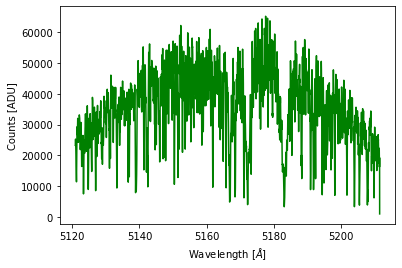

In [16]:
pl.plot(wl_solution[2,:],flux[2,:],'g')
pl.ylabel("Counts [ADU]")
pl.xlabel("Wavelength [$\AA$]")
pl.show()

In [25]:
#Continumm Normalization 

import matplotlib.pyplot as plt 
import numpy as np 
from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum


In [3]:
wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])

In [19]:
data.download("deblazed/r20071124.121.fits")

{'status': 'ok', 'msg': ''}

In [4]:
deblazedFlux = fits.getdata("output/r20071124.121.fits")
deblazedFlux = np.append(deblazedFlux[0],[deblazedFlux[i] for i in range(1,16)])/9.0e3

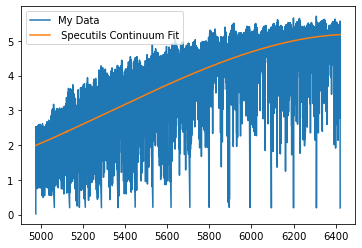

In [5]:

x = wl_solution
y = deblazedFlux
plt.plot(x, y, label = 'My Data', c='C0')

spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)
g1_fit = fit_generic_continuum(spectrum)
y_fit = g1_fit(x*u.um)

plt.plot(x, y_fit, label = ' Specutils Continuum Fit', c='C1')
plt.legend()

In [69]:
plt.plot(x,y - y_fit/u.Jy,label = 'contrinum subtracted')\
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-69-ea4fa3aa7c87>, line 2)

In [7]:
normalizedFlux = y - y_fit/u.Jy

In [ ]:
#Cross-corrlate 

In [ ]:
#-=================================

In [3]:
h = fits.open("output/r20071124.121.fits")

In [7]:
h = fits.open("output/r20071124.121.fits")
hdu = h[0]
hdu.header

In [2]:
import math
math.log10()

In [2]:
#Interpolate

In [8]:
d = {"Hello":(0,1),"There":(2,3)}

In [22]:
fluxnorm = [np.float64(i) for i in normalizedFlux]

In [9]:
wlDic = {}
fluxDic = {}
for HIRES_ID in spectraDic:
    wl = spectraDic[HIRES_ID][0]
    flux = spectraDic[HIRES_ID][1]
    intfunc = interpolate.interp1d(wl,flux)
    wlDic[HIRES_ID] = wl
x    fluxDic[HIRES_ID] = intfunc(wl)

return pd.DataFrame(wlDic), pd.DataFrame(fluxDic)
    


NameError: name 'spectraDic' is not defined

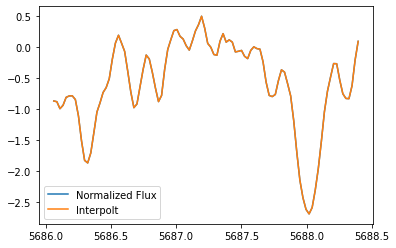

In [16]:
# get the interpolating function (you need to choose which type)
intfunc = interpolate.interp1d(x,fluxnorm,assume_sorted = True)
# plot interpolated data at high sampling
start = 35236
stop = 35336

plt.plot(x[start:stop],fluxnorm[start:stop],label = "Normalized Flux")
plt.plot(x[start:stop],intfunc(x)[start:stop],label = "Interpolt")
plt.legend()
plt.show()

In [15]:
interpolate_over = [wl for wl in x if wl >= 5000 and wl<=6000]

In [23]:

test_Interpolation = np.interp(interpolate_over,x,fluxnorm)

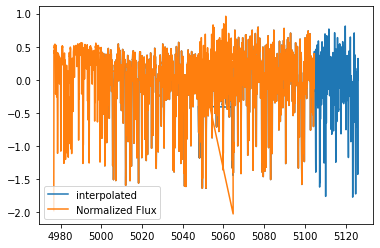

In [31]:
start = 0
stop  = 6500
plt.plot(interpolate_over[start:stop],test_Interpolation[start:stop],label = "interpolated")
plt.plot(x[start:stop],fluxnorm[start:stop],label = "Normalized Flux")
plt.legend()
plt.show()

In [3]:
#Counts to Erg/s 
#If you know the total number of counts (N) collected and the total time (t, in seconds) over which 
#the photons were collected, the rate at which the photons were collected is N/t (with units of photons/second). 
#You also have the wavelength associated with each point in the spectrum, so you can convert that to 
#energy (ergs) using E = hc/lambda, where lambda is the wavelength of light.
wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])
deblazedFlux = fits.getdata("output/r20071124.121.fits")
deblazedFlux = np.append(deblazedFlux[0],[deblazedFlux[i] for i in range(1,16)])

In [8]:
hdu = fits.open("output/r20071124.121.fits")
timeElapsed = hdu[0].header["ELAPTIME"]

In [9]:
photonsPersec = deblazedFlux/timeElapsed

In [65]:
ergsPerSecFlux = []
for i in range(len(photonsPersec)):
    photonEnergy = 1.2398 / (wl_solution[i]*0.0001) #h*c = 1.2398 eV-µm
    ergsPerSec = photonEnergy*photonsPersec[i]
    ergsPerSecFlux.append(ergsPerSec)
ergsPerSecFlux = np.array(ergsPerSecFlux)

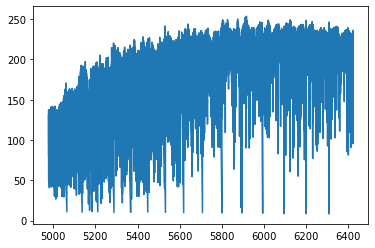

In [66]:
start = 50
stop  = len(wl_solution)-1
plt.plot(wl_solution[start:stop],ergsPerSecFlux[start:stop])
plt.show()

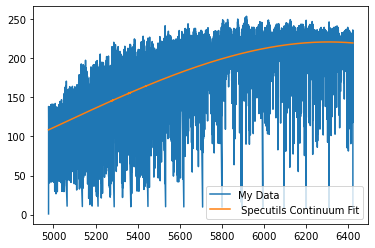

In [67]:
x = wl_solution
y = ergsPerSecFlux
plt.plot(x, y, label = 'My Data', c='C0')

spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)
g1_fit = fit_generic_continuum(spectrum)
y_fit = g1_fit(x*u.um)

plt.plot(x, y_fit, label = ' Specutils Continuum Fit', c='C1')
plt.legend()

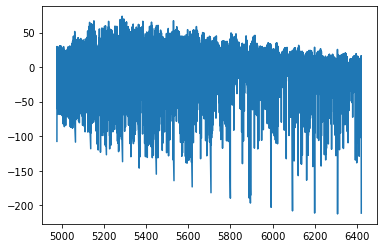

In [68]:
plt.plot(x,y - y_fit/u.Jy,label = 'contrinum subtracted')
plt.show()

In [5]:

t = np.array([-420,12,-1000,3])

In [6]:
t.min()

-1000

In [7]:
maxMinVal = float('-inf')
minMaxVal = float('inf')


-inf

In [23]:
dictest = {'OP':("23432",1),".GG":(2,3)}

In [24]:
for val in dictest.values():
    print(val)

('23432', 1)
(2, 3)


In [20]:
next(iter(dictest))

'OP'

In [25]:
len(dictest["OP"][0])

5

In [21]:
k = next(iter(dictest))
for i in dictest.values():
    print(i)

(0, 1)
(2, 3)


In [26]:
d = [23,231,123,1,23,4,5]

In [27]:
d[len(d)]

IndexError: list index out of range